# Categorical Handling con XGBoost

In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [2]:
# Load the dataset 
X = pd.read_csv("../datasets/dat_sanidad.csv", sep=';', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [3]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596,21,0,1,151,Q,1,0
1,4,0.306931,20973,22,0,1,99,Q,1,0
2,4,0.278481,19611,19,0,1,87,Q,1,0
3,3,0.150289,13583,22,0,1,100,Q,1,0
4,1,0.016573,18042,2,0,1,44,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4.

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD.
        
- **edad_dias**: Edad en días del paciente.

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas.
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso.
    
- **proc**: Procedencia del paciente.

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial.

- **tipgrd**: GRD médico (M) o de quirófano (Q).
    
- **tiping**: Tipo de ingreso: Programado, urgente...
    
- **exitus**: 1 = El paciente falleció.

De estas variables, fecing la usaremos para realizar el split en train/validacion/test, exitus es el target y las 10 variables restantes serán el input de nuestro modelo.

### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [4]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal.

In [5]:
y = X['exitus']
del X['exitus']

# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])


## XGBoost

Vamos a aplicar ahora un modelo de XGBoost para intentar predecir la probabilidad de exitus en función de todas las otras variables de las que disponemos en el dataset. Recordemos que la definición de Gradient Boosting es la siguiente:

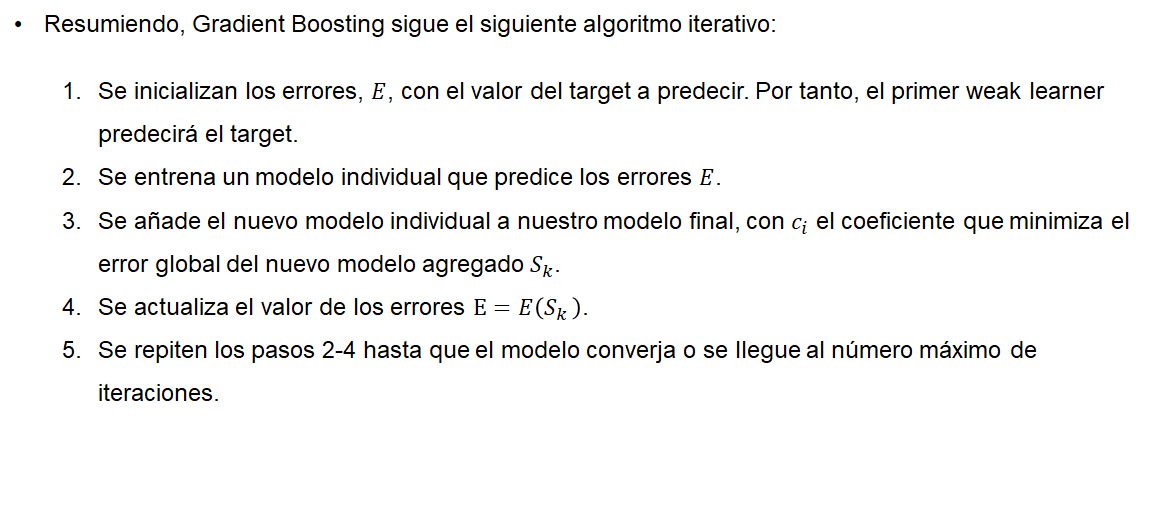

### Versión 1: One-Hot Encoding

In [6]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)


# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]


1) Importar modelo.

In [7]:
from xgboost import XGBClassifier as model_constructor

2) Importar métrica.

In [8]:
from sklearn.metrics import roc_auc_score as metric

3) Definir el método.

In [9]:
model = model_constructor(random_state = 1)

4) Llamar al método fit para entrenar el modelo. 

In [10]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_val, y_val)],
          early_stopping_rounds = 10,
          verbose=True)

[0]	validation_0-auc:0.92503
[1]	validation_0-auc:0.91893
[2]	validation_0-auc:0.92020
[3]	validation_0-auc:0.92484
[4]	validation_0-auc:0.92759
[5]	validation_0-auc:0.92179
[6]	validation_0-auc:0.90473
[7]	validation_0-auc:0.91601
[8]	validation_0-auc:0.92099
[9]	validation_0-auc:0.92376


C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.92253
[11]	validation_0-auc:0.92452
[12]	validation_0-auc:0.92615
[13]	validation_0-auc:0.92695
[14]	validation_0-auc:0.92588


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

5) Llamar al método predict para generar las predicciones.

In [11]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test) 

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [12]:
# Calcular métricas de evaluación
auc_train = metric(y_train, pred_train_p[:,1]);
auc_val = metric(y_val, pred_val_p[:,1]);
auc_test = metric(y_test, pred_test_p[:,1]);
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['XGBoost OHE'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)

In [13]:
results

,model,auc_train,auc_val,auc_test
0,XGBoost OHE,0.959265,0.927589,0.916104


### Versión 2: OHE + tree_method = 'hist'

XGBoost ofrece distintas formas de elegir las particiones y construir los árboles. Una muy popular es tree_method = 'hist', que permite acelerar los modelos cuando se trabaja con grandes datasets (approach similar a LightGBM).

3) Definir el método.

In [14]:
model = model_constructor(random_state = 1,  tree_method = 'hist')

4) Llamar al método fit para entrenar el modelo. 

In [15]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_val, y_val)],
          early_stopping_rounds = 10,
          verbose=True)

[0]	validation_0-auc:0.89724
[1]	validation_0-auc:0.91853
[2]	validation_0-auc:0.92261
[3]	validation_0-auc:0.92769
[4]	validation_0-auc:0.92363
[5]	validation_0-auc:0.92377
[6]	validation_0-auc:0.92750
[7]	validation_0-auc:0.92128
[8]	validation_0-auc:0.92424
[9]	validation_0-auc:0.92575
[10]	validation_0-auc:0.92916
[11]	validation_0-auc:0.92980
[12]	validation_0-auc:0.93024
[13]	validation_0-auc:0.93293
[14]	validation_0-auc:0.93369
[15]	validation_0-auc:0.93374
[16]	validation_0-auc:0.93382
[17]	validation_0-auc:0.93386
[18]	validation_0-auc:0.93260
[19]	validation_0-auc:0.93275
[20]	validation_0-auc:0.93298


C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.93305
[22]	validation_0-auc:0.93257
[23]	validation_0-auc:0.93004
[24]	validation_0-auc:0.93029
[25]	validation_0-auc:0.92991
[26]	validation_0-auc:0.92931


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

5) Llamar al método predict para generar las predicciones.

In [16]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test) 

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [17]:
# Calcular métricas de evaluación
auc_train = metric(y_train, pred_train_p[:,1]);
auc_val = metric(y_val, pred_val_p[:,1]);
auc_test = metric(y_test, pred_test_p[:,1]);
results = results.append(pd.DataFrame(data={'model':['XGBoost OHE + hist'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)

In [18]:
results

,model,auc_train,auc_val,auc_test
0,XGBoost OHE,0.959265,0.927589,0.916104
1,XGBoost OHE + hist,0.970494,0.933863,0.928994


### Versión 3: tree_method = 'hist'

Esta vez no realizaremos ningún paso de preprocesado, por lo que **no realizaremos encoding**. Para ello debemos de indicar que las variables son categóricas.

In [19]:
# Load the dataset 
X = pd.read_csv("../datasets/dat_sanidad.csv", sep=';', decimal=',', encoding='latin-1')
y = X['exitus']
del X['exitus']

In [20]:
X[['gravedad', 'proc', 'tiping', 'tipgrd']] = X[['gravedad', 'proc', 'tiping', 'tipgrd']].astype("category")
X.dtypes

gravedad                category
pct_mortalidad_norma     float64
edad_dias                  int64
numproc                    int64
potencial_ambul            int64
proc                    category
estancia_esperada          int64
tipgrd                  category
tiping                  category
dtype: object

In [21]:
# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

3) Definir el método.

Para activar el manejo de variables categóricas tenemos que indicar el flag *enable_categorical*. Para que funcione es obligatorio indicar tree_method = 'hist', o tree_method = 'gpu_hist'.

In [22]:
model = model_constructor(random_state = 1,
                      tree_method = 'hist',
          enable_categorical = True)

4) Llamar al método fit para entrenar el modelo. 

En este caso, dejaremos que el propio modelo gestione tanto las variables categóricas.

In [23]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_val, y_val)],
          early_stopping_rounds = 10,
          verbose=True)

[0]	validation_0-auc:0.90846
[1]	validation_0-auc:0.92665
[2]	validation_0-auc:0.92723
[3]	validation_0-auc:0.93482
[4]	validation_0-auc:0.93566
[5]	validation_0-auc:0.93614
[6]	validation_0-auc:0.93970
[7]	validation_0-auc:0.93955
[8]	validation_0-auc:0.93937
[9]	validation_0-auc:0.93911
[10]	validation_0-auc:0.93967
[11]	validation_0-auc:0.94020
[12]	validation_0-auc:0.94028
[13]	validation_0-auc:0.94036
[14]	validation_0-auc:0.94021
[15]	validation_0-auc:0.94035
[16]	validation_0-auc:0.94235
[17]	validation_0-auc:0.94267
[18]	validation_0-auc:0.94233


C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.94218
[20]	validation_0-auc:0.94244
[21]	validation_0-auc:0.94256
[22]	validation_0-auc:0.94260
[23]	validation_0-auc:0.94252
[24]	validation_0-auc:0.94240
[25]	validation_0-auc:0.94233
[26]	validation_0-auc:0.94222
[27]	validation_0-auc:0.94257


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

5) Llamar al método predict para generar las predicciones.

In [24]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test) 

6) Calcular métrica usando las predicciones obtenidas en el paso anterior.

In [25]:
# Calcular métricas de evaluación
auc_train = metric(y_train, pred_train_p[:,1]);
auc_val = metric(y_val, pred_val_p[:,1]);
auc_test = metric(y_test, pred_test_p[:,1]);
results = results.append(pd.DataFrame(data={'model':['XGBoost internal handling + hist'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)

In [26]:
results

,model,auc_train,auc_val,auc_test
0,XGBoost OHE,0.959265,0.927589,0.916104
1,XGBoost OHE + hist,0.970494,0.933863,0.928994
2,XGBoost internal handling + hist,0.967844,0.942672,0.937665


Veamos cuál es la mejor aproximación...

In [27]:
results['model'][results['auc_test'].idxmax()]

'XGBoost internal handling + hist'